In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

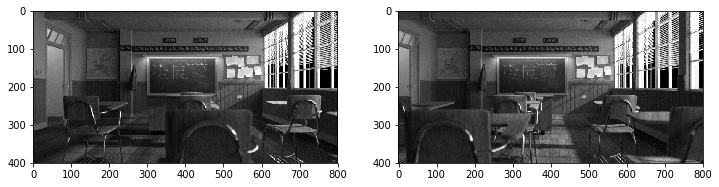

In [6]:
fn1 = "/Users/ejoseph/Documents/blender-scene/cam1.png"
fn2 = "/Users/ejoseph/Documents/blender-scene/cam2.png"

im1 = cv2.cvtColor(cv2.imread(fn1), cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(cv2.imread(fn2), cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(im1, cmap='gray')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(im2, cmap='gray')

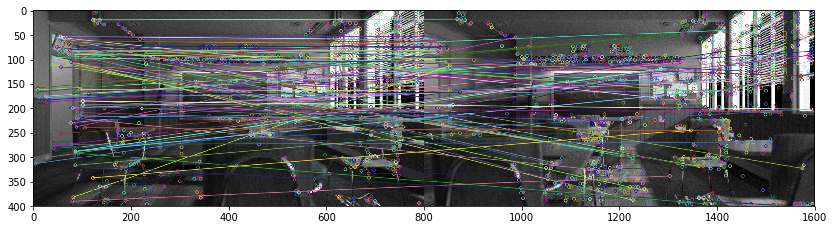

In [41]:
# Extract features and match
features_extractor = cv2.xfeatures2d.SIFT_create()
matcher = cv2.FlannBasedMatcher_create()
kp1, des1 = features_extractor.detectAndCompute(im1, mask=None)
kp2, des2 = features_extractor.detectAndCompute(im2, mask=None)
matches = matcher.match(queryDescriptors=des1, trainDescriptors=des2)

# Draw matches
im_matches = cv2.drawMatches(img1=im1, keypoints1=kp1, img2=im2, keypoints2=kp2, matches1to2=matches[:100], outImg=None)
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(im_matches);

In [96]:
# Do RANSAC to find optimal Fundemental matrix

# Array of aligend matches between the images
uv1 = np.array([kp1[m.queryIdx].pt for m in matches])
uv2 = np.array([kp2[m.trainIdx].pt for m in matches])

max_iter = 1
for i in range(max_iter):
    inds = np.random.randint(low=0, high=len(matches), size=8)
    pts1 = uv1[inds]
    pts2 = uv2[inds]
    # Build 9x9 square matrix
    a = np.vstack((
        pts2[:, 0]*pts1[:, 0],
        pts2[:, 0]*pts1[:, 1],
        pts2[:, 0],
        pts2[:, 1]*pts1[:, 0],
        pts2[:, 1]*pts1[:, 1],
        pts2[:, 1],
        pts1[:, 0],
        pts1[:, 1])).T
    
U, D, Vt = np.linalg.svd(A)
D[-1] = 0
D
# U.shape


array([7.88860425e+05, 1.74032988e+05, 1.27115954e+05, 2.10154689e+04,
       3.43787159e+02, 1.70827340e+02, 4.67635375e+01, 0.00000000e+00])

In [121]:
cam_mtx = np.array([[254.73, 0, 399.5],
                   [0, 254.73, 0, 199.5],
                   [0, 0, 1]])
# F, mask = cv2.findFundamentalMat(uv1, uv2, method=cv2.FM_RANSAC, param1=3, param2=0.99)
E, mask = cv2.findEssentialMat(points1=uv1, points2=uv2, focal=cam_mtx[0][0], pp=(cam_mtx[0][2], cam_mtx[1][2]),
                              method=cv2.RANSAC, threshold=2, prob=0.99)
E
_, R, t, mask =cv2.recoverPose(E, uv1, uv2)
t

array([[-0.99931016],
       [-0.00883705],
       [-0.03607099]])

# Solving for the Fundemental matrix

$
\left[
\begin{matrix} 
u & v & 1 \\
\end{matrix}
\right]
\left[
\begin{matrix} 
f_{11} & f_{12} & f_{13} \\
f_{21} & f_{22} & f_{23} \\
f_{31} & f_{32} & f_{33} \\
\end{matrix}
\right]
\left[
\begin{matrix} 
u' \\ v' \\ 1 \\
\end{matrix}
\right] = 0
$

Because the equation is homegenous, we can divide by $f_{33}$ and we have only 8 unknowns.

$
\left[
\begin{matrix} 
u & v & 1 \\
\end{matrix}
\right]
\left[
\begin{matrix} 
f_{1} & f_{2} & f_{3} \\
f_{4} & f_{5} & f_{6} \\
f_{7} & f_{8} & 1 \\
\end{matrix}
\right]
\left[
\begin{matrix} 
u' \\ v' \\ 1 \\
\end{matrix}
\right] = 0
$

Given that we have at least 4 points, we can write it as:

$
\left[
\begin{matrix} 
u_1' u_1 & u_1' v_1 & u_1' & v_1' u_1 & v_1' v_1 & v_1' & u_1 & v_1 & 1 \\
u_2' u_2 & u_2' v_2 & u_2' & v_2' u_2 & v_2' v_2 & v_2' & u_2 & v_2 & 1 \\
\vdots  \\
u_n' u_n & u_n' v_n & u_n' & v_n' u_n & v_n' v_n & v_n' & u_n & v_n & 1 \\
\end{matrix}
\right]_{n \times 9}
\left[
\begin{matrix} 
f_1 \\ f_2 \\ f_3 \\ f_4 \\ f_5 \\ f_6 \\ f_7 \\ f_8 \\ 1 \\
\end{matrix}
\right]_{9 \times 1} = 0
$

We can solve this equation using SVD.

Yet, to make $\mathbf{F}$ really a Fundemental matrix with rank 2, we need to decompose it using SVD and make the smallest eigen-value 0.

$\mathbf{F} = \mathbf{U} \mathbf{D} \mathbf{V}^T$

$\mathbf{D} = \left[
\begin{matrix} 
d_1 & 0 & 0 \\
0 & d_2 & 0 \\
0 & 0 & d_3 \\
\end{matrix}
\right]$

Where $d_1 > d_2 > d_3$.
We set $d_3=0$, such that:

$\hat{\mathbf{D}} = \left[ \begin{matrix} 
d_1 & 0 & 0 \\
0 & d_2 & 0 \\
0 & 0 & 0 \\
\end{matrix} \right]
$ 

and reconstruct $\mathbf{F}$:

$\hat{\mathbf{F}} = \mathbf{U} \hat{\mathbf{D}} \mathbf{V}^T$

In [90]:
help(cv2.findFundamentalMat)

Help on built-in function findFundamentalMat:

findFundamentalMat(...)
    findFundamentalMat(points1, points2[, method[, param1[, param2[, mask]]]]) -> retval, mask
    .   @brief Calculates a fundamental matrix from the corresponding points in two images.
    .   
    .   @param points1 Array of N points from the first image. The point coordinates should be
    .   floating-point (single or double precision).
    .   @param points2 Array of the second image points of the same size and format as points1 .
    .   @param method Method for computing a fundamental matrix.
    .   -   **CV_FM_7POINT** for a 7-point algorithm. \f$N = 7\f$
    .   -   **CV_FM_8POINT** for an 8-point algorithm. \f$N \ge 8\f$
    .   -   **CV_FM_RANSAC** for the RANSAC algorithm. \f$N \ge 8\f$
    .   -   **CV_FM_LMEDS** for the LMedS algorithm. \f$N \ge 8\f$
    .   @param param1 Parameter used for RANSAC. It is the maximum distance from a point to an epipolar
    .   line in pixels, beyond which the point i

In [7]:
help(cv2)

Help on package cv2.cv2 in cv2:

NAME
    cv2.cv2 - Python wrapper for OpenCV.

PACKAGE CONTENTS
    cv2
    data (package)

CLASSES
    builtins.Exception(builtins.BaseException)
        cv2.error
    builtins.object
        cv2.Algorithm
            cv2.AlignExposures
                cv2.AlignMTB
            cv2.BackgroundSubtractor
                cv2.BackgroundSubtractorKNN
                cv2.BackgroundSubtractorMOG2
                cv2.bgsegm_BackgroundSubtractorCNT
                cv2.bgsegm_BackgroundSubtractorGMG
                cv2.bgsegm_BackgroundSubtractorGSOC
                cv2.bgsegm_BackgroundSubtractorLSBP
                cv2.bgsegm_BackgroundSubtractorMOG
            cv2.BaseCascadeClassifier
            cv2.CLAHE
            cv2.CalibrateCRF
                cv2.CalibrateDebevec
                cv2.CalibrateRobertson
            cv2.DenseOpticalFlow
                cv2.DualTVL1OpticalFlow
                cv2.FarnebackOpticalFlow
                cv2.optflow_DISOptical